# Portfolio Optimization
This notebook demonstrates portfolio optimization techniques and estimator variability. Portfolios are a collection of assets in which each asset is allocated a percentage of the portfolio's capital. This notebook explores different schemes for capital allocation across its holdings. Because portfolio optimization functions are estimators, we will measure estimator variability with bootstrapping.

In [93]:
# Notebook imports
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-pastel')

## 1. Mean-Variance Optimization


#### 2-Asset Portfolio
Assets yield returns. Suppose we are a risk-averse investor and would like to allocate our money between two assets with returns X and Y, where X and Y are random continuous variables. We want to determine the allocation that minimizes total portfolio risk (variance) but maximizes the expected return. To start, we consider a simple portfolio with two assets. We then extend the concept to an N-asset portfolio.<br><br>
 $\alpha$ denotes the allocation to X and $1-\alpha$ denotes the allocation to Y. The total portfolio is then represented as the equation $\alpha*X + (1-\alpha)*Y$. The variance of the portfolio is:<br><br>
$Var(\alpha*X + (1-\alpha)*Y)$<br><br>
This is transformed into a minimization and maximization problem. We want to minimze variance and maximize expected return.<br>
DERIVATION HERE

In [94]:
X = 'SPY' # S&P 500 Index
Y = 'DIA' # Dow-Jones Industrial Average

# Download monthly data
data = yf.download(tickers=[X, Y], interval='1mo', period='max', auto_adjust=True)['Close']

# Calculate the monthly returns
data[X] = data[X].pct_change()
data[Y] = data[Y].pct_change()

# Clean the data
data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(columns='Date', inplace=True)

# Display the summary statistics of the returns
print(data.describe())

[*********************100%***********************]  2 of 2 completed

Ticker         DIA         SPY
count   328.000000  328.000000
mean      0.007764    0.007809
std       0.043895    0.045029
min      -0.154253   -0.160354
25%      -0.016279   -0.016705
50%       0.010793    0.013423
75%       0.031763    0.034858
max       0.142675    0.133610


In [95]:
def mean_variance_two(df, idx, X='SPY', Y='DIA'):
    """
    * mean_variance_two()
    * Calculates the alpha parameter of a two-asset portfolio. Alpha is
    * the allocation to the X asset in a portfolio. Uses mean-variance
    * optimization.
    *
    * df:  Dataframe of asset returns.
    * idx: Index defining observations to use in the calculations.
    *      Used for bootstrap resampling.
    * X:   Label of the X asset.
    * Y:   Label of the Y asset.
    *
    * returns the alpha parameter
    """

    covariance = np.cov(df[[X, Y]].loc[idx], rowvar=False)

    # Minimized portfolio variance
    return (covariance[1,1] - covariance[0,1]) / (covariance[0,0] + covariance[1,1] - 2 * covariance[0,1])

alpha = mean_variance_two(data, range(len(data)))
print(f'{X} weight = {alpha:.4f} | {Y} weight = {(1-alpha):.4f}')

SPY weight = 0.2811 | DIA weight = 0.7189


##### Measuring Variability with Bootstrapping
DESCRIPTION HERE

0.20039382743018022


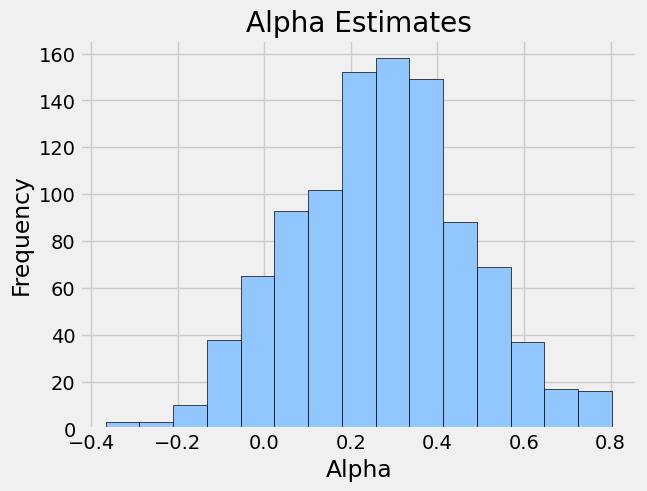

In [96]:
def bootstrapped_mv2_SE(func, data, B=1000, seed=0):
    """
    * bootstrapped_mv2_SE()
    * Calculates the estimated standard error for the alpha parameter using the bootstrap
    * technique. Assumes that it is only a two-asset portfolio.
    *
    * func: Function to calculate the alpha parameter.
    * data: Dataframe of asset returns.
    * B:    Number of bootstrap replications.
    * seed: Random seed for reproducability.
    """

    random_rng = np.random.default_rng(seed)
    n = len(data) # Number of observations to use in the index range

    # Standard error parameters
    se_first, se_second = 0, 0

    alpha_estimates = np.zeros(B)

    for i in range(B):
        # Index range with replacement
        idx = random_rng.choice(data.index, n, replace=True)

        alpha_value = func(data, idx)
        alpha_estimates[i] = alpha_value

        # Update the standard error parameters
        se_first += alpha_value
        se_second += alpha_value ** 2

    return np.sqrt(se_second / B - (se_first / B) ** 2), alpha_estimates

# Compute the estimated alpha standard error
alpha_se, alpha_estimates = bootstrapped_mv2_SE(mean_variance_two, data)

# Print the standard error of the alpha
print(alpha_se)

# Plot the estimates of alpha generated by simulated samples from the true
# SPY-DIA dataset.
plt.hist(alpha_estimates, bins=15, edgecolor='black')
plt.title('Alpha Estimates')
plt.xlabel('Alpha')
plt.ylabel('Frequency')
plt.show()

For a random sample from the population of SPY-DIA returns, we would expect the estimated alpha (allocation to X) to differ from the true alpha by approximately 0.2 on average. CONCLUSION HERE

#### N-Asset Portfolio